# Rolling GeoMAD

* **Products used:** 
[gm_s2_rolling](https://explorer.digitalearth.africa/gm_s2_rolling),
[ndvi_anomaly](https://explorer.digitalearth.africa/s2_l2a)

## Background

Satellite imagery allows us to observe the Earth in a repetitive and detailed manner. However, missing data &mdash; such as gaps caused by cloud cover &mdash; can make it difficult to put together a complete image. In order to produce a single, complete view of a certain area, satellite data may be consolidated, stacking measurements from different points in time to create a composite image.

The Digital Earth Africa (DE Africa) Sentinel-2 Rolling GeoMAD (**Geo**median and **M**edian **A**bsolute **D**eviations) service provides monthly Geomedian and MADs calculated using a moving window of 3 months . This is a cloud-free time series that can be used to monitor change on a more frequent basis than an annual or semiannual product.

Each product combines measurements collected over a 3-month period to produce one representative, multi-spectral image for every pixel of the African continent for each calendar month. The end result is a comprehensive dataset that can be used either to generate true-colour images for visual inspection of the landsacpe, or the full spectral dataset can be used to develop more complex algorithms.

**Important details:**

* Datacube product names: `gm_s2_rolling`
* Geomedian surface reflectance product
    * Valid scaling range: `1 - 10,000`
    * `0` is `no data`
* Median Absolute Deviation product
    * Valid scaling range: Spectral MAD: `0 - 1` , Bray-Curtis MAD `0 - 1`, Euclidean MAD `0 - 10,000` 
    * `NaN` is `nodata`
* Status: provisional
* Date-range: October 2020 &ndash; present
* Spatial resolution: 10m

For more information on DE Africa's GeoMAD service, see the DE Africa [GeoMAD](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html).

## Description

In this notebook we will work with the Sentinel-2 Rolling GeoMAD and Mean NDVI and Anomalies products.
>Note: The GeoMAD product is suitable for calculating any indices, not just NDVI.

Topics covered include:
1. Inspecting the Rolling GeoMAD products and measurements available in the datacube
2. Load Rolling GeoMAD data
3. Display rgb of Rolling GeoMAD
4. Calculate NDVI from Rolling GeoMAD
5. Load NDVI monthly mean data
6. Plot the NDVI from Rolling GeoMAD and NDVI monthly mean
7. Compare zonal average NDVI from Rolling GeoMAD and NDVI monthly mean curve
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [31]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datacube
from datacube.utils.geometry import Geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='rolling_geomad')

### List measurements

Inspect the measurement or bands available for the Sentinel-2 Rolling GeoMAD using datacube's `list_measurements` functionality.

In [3]:
product_name = 'gm_s2_rolling'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,name,dtype,units,nodata,aliases
measurement,,,,,
B02,B02,uint16,1,0.0,"[band_02, blue]"
B03,B03,uint16,1,0.0,"[band_03, green]"
B04,B04,uint16,1,0.0,"[band_04, red]"
B05,B05,uint16,1,0.0,"[band_05, red_edge_1]"
B06,B06,uint16,1,0.0,"[band_06, red_edge_2]"
B07,B07,uint16,1,0.0,"[band_07, red_edge_3]"
B08,B08,uint16,1,0.0,"[band_08, nir, nir_1]"
B8A,B8A,uint16,1,0.0,"[band_8a, nir_narrow, nir_2]"
B11,B11,uint16,1,0.0,"[band_11, swir_1, swir_16]"


### Define area of interest

In [4]:
#Specify the latitude, longitude, and buffer
aoi = define_area(lat=-21.07, lon=31.53, buffer=0.03)

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

### Display area of interest with a basemap using `display_map()`

In [5]:
display_map(x=lon_range, y=lat_range)

### Load Sentinel-2 Rolling GeoMAD data using `dc.load()`. 
For a more discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

>Note: For Rolling GeoMAD the loaded dataset will load the`time range` inclusing the month before the `intial date` and also the following month after the `final date`. This is due to the 3 months rolling window calculation.

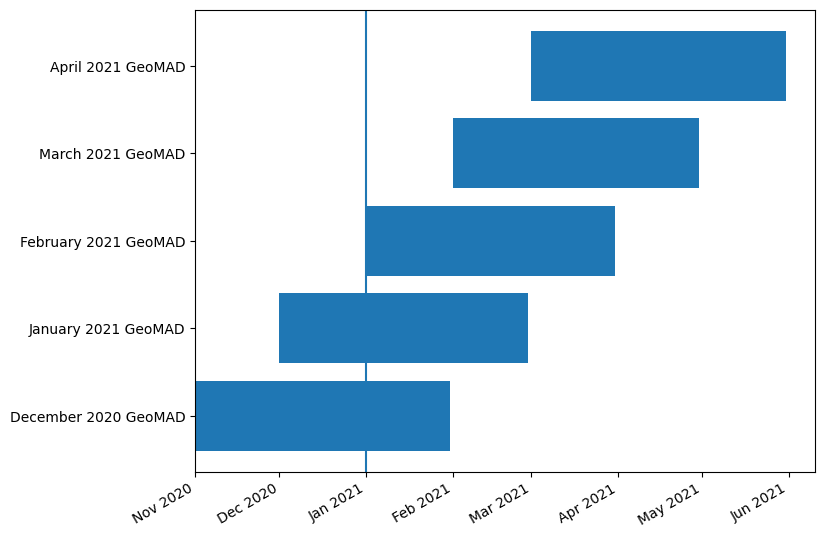

In [38]:
begin = np.array(["2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01", "2021-03-01"])
end =   np.array(["2021-01-31", "2021-02-28", "2021-03-31", "2021-04-30", "2021-05-31"])

begin = [datetime.strptime(i, "%Y-%m-%d") for i in begin]
end = [datetime.strptime(i, "%Y-%m-%d") for i in end]

event = ["December 2020 GeoMAD", "January 2021 GeoMAD", "February 2021 GeoMAD", "March 2021 GeoMAD", "April 2021 GeoMAD"]

fig, ax = plt.subplots(figsize=(8,6))

plt.barh(range(len(begin)),  [(end[i]-begin[i]) for i in range(len(begin))], left=begin)

plt.yticks(range(len(begin)), event)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.axvline(x=datetime.strptime("2021-01-01", "%Y-%m-%d"))
plt.show()

In [27]:
begin = np.array(["2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01", "2021-03-01"])
end =   np.array(["2021-01-31", "2021-02-28", "2021-03-31", "2021-04-30", "2021-05-31"])

begin = [datetime.strptime(i, "%Y-%m-%d") for i in begin]
end = [datetime.strptime(i, "%Y-%m-%d") for i in end]

[(end[i]-begin[i]) for i in range(len(begin))]

[datetime.timedelta(days=91),
 datetime.timedelta(days=89),
 datetime.timedelta(days=89),
 datetime.timedelta(days=88),
 datetime.timedelta(days=91)]

In [7]:
ds = dc.load(product="gm_s2_rolling",
             measurements=['red','green','blue','nir','EMAD', 'SMAD', 'BCMAD'],
             x=lon_range,
             y=lat_range,
             resolution=(-20, 20),
             output_crs = 'epsg:6933',
             time=("2021-01","2021-12"),
             
             )
display(ds)

<xarray.Dataset>
Dimensions:      (time: 14, y: 359, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 2020-12-16T23:59:59.999999 ... 2022-01...
  * y            (y) float64 -2.626e+06 -2.626e+06 ... -2.633e+06 -2.633e+06
  * x            (x) float64 3.039e+06 3.039e+06 ... 3.045e+06 3.045e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 595 573 543 851 661 ... 1027 983 779 648
    green        (time, y, x) uint16 712 698 656 872 780 ... 1061 1026 929 886
    blue         (time, y, x) uint16 458 452 421 538 468 ... 661 728 704 638 597
    nir          (time, y, x) uint16 2634 2607 2514 2949 ... 3863 3712 3597 3663
    EMAD         (time, y, x) float32 1.858e+03 1.863e+03 ... 1.197e+03
    SMAD         (time, y, x) float32 0.02137 0.01984 ... 0.001466 0.002157
    BCMAD        (time, y, x) float32 0.1483 0.1527 0.1337 ... 0.07304 0.07646
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Slicing the time to get the actual time range specified. (Compared the ds below to the ds result above, noticed that the time is reduced in the below cells)

In [8]:
ds_time = ds.time[1:-1]
ds = ds.sel(time=ds_time.values)
display(ds)

<xarray.Dataset>
Dimensions:      (time: 12, y: 359, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-14T23:59:59.999999 ... 2021-12...
  * y            (y) float64 -2.626e+06 -2.626e+06 ... -2.633e+06 -2.633e+06
  * x            (x) float64 3.039e+06 3.039e+06 ... 3.045e+06 3.045e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 332 336 339 678 475 ... 1053 1007 802 636
    green        (time, y, x) uint16 583 602 557 781 693 ... 1027 983 900 838
    blue         (time, y, x) uint16 317 332 320 451 376 ... 640 704 678 622 561
    nir          (time, y, x) uint16 3159 3204 2827 3226 ... 3475 3392 3313 3353
    EMAD         (time, y, x) float32 883.5 698.1 756.0 ... 805.6 725.1 679.8
    SMAD         (time, y, x) float32 0.0004319 0.0004552 ... 0.001784 0.002771
    BCMAD        (time, y, x) float32 0.0666 0.0551 0.05762 ... 0.05421 0.04862
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Display rgb of Sentinel-2 Rolling GeoMAD

We can plot the data we loaded using the `rgb()` function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.

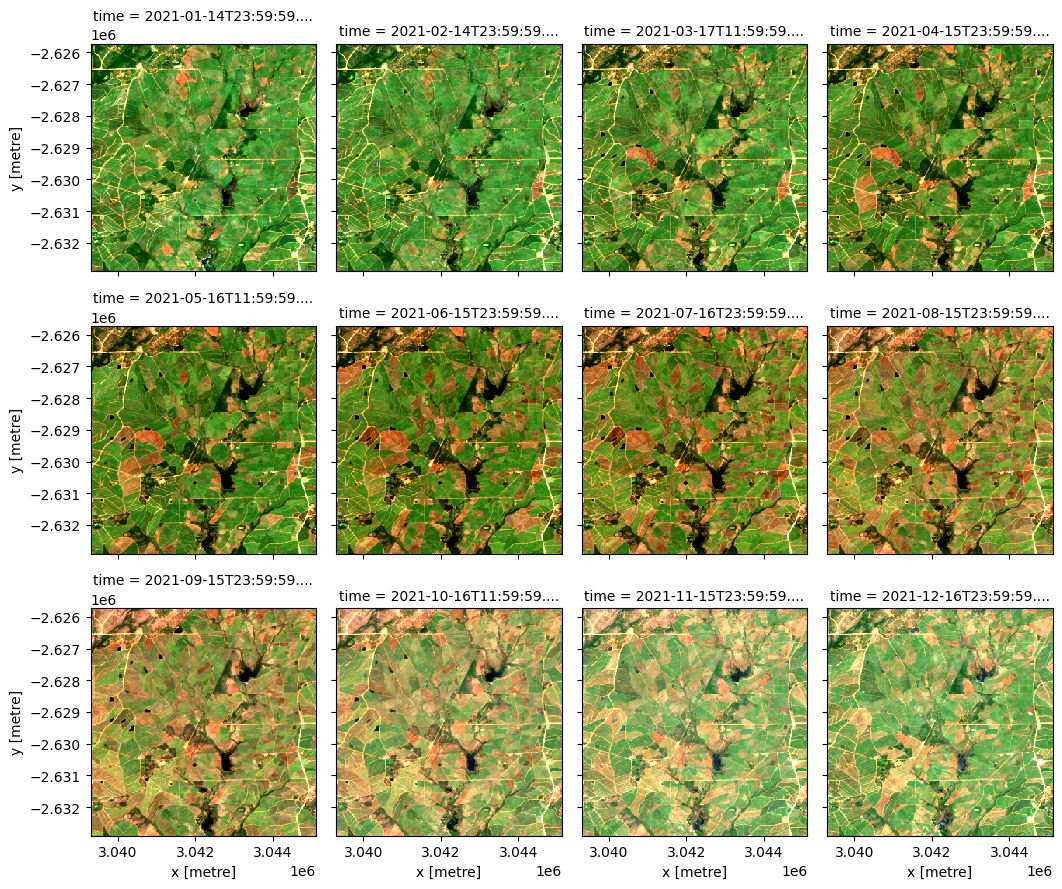

In [9]:
rgb(ds, col='time', col_wrap=4, size=3)

### Calculate NDVI using `calculate indices`
Refer to the [Calculating band indices](../Frequently_used_code/Calculating_band_indices.ipynb) notebook for more information. 
>Note: This product is suitable for calculating any indices, not just NDVI.

In [10]:
ds_NDVI = calculate_indices(ds, index=['NDVI'], satellite_mission='s2')

### Load monthly mean NDVI data using `dc.load()`.
Refer to the [NDVI Anomaly](../Datasets/NDVI_Anomaly.ipynb) notebook for more information NDVI mean.

In [11]:
monthly_ndvi = dc.load(
    product="ndvi_anomaly",
    time=("2021-01", "2021-12"),
    measurements = ['ndvi_mean'],
    like = ds.geobox,
)

#### Plot NDVI for selected months

NDVI for Rolling GeoMAD and Monthly Mean are plotted for January, April, July and November 2021, to visualise the area of interest. The output of these results will also be compared.

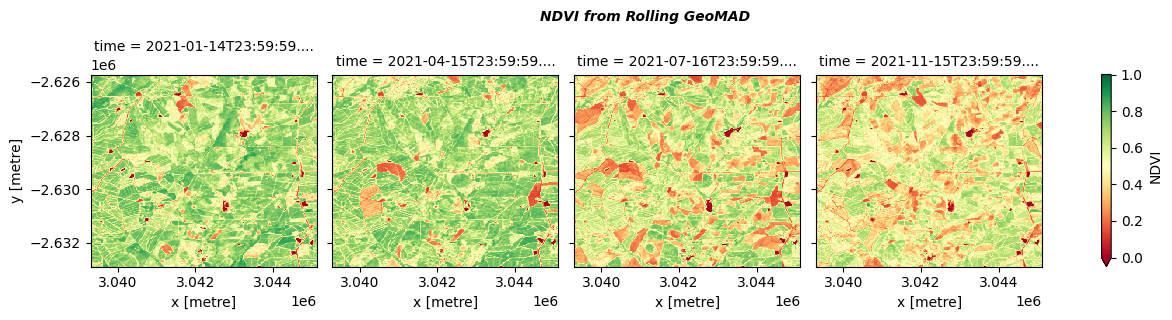

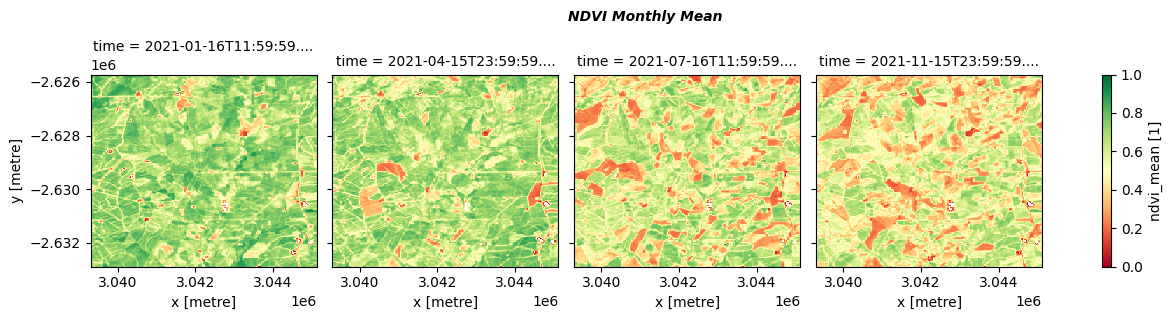

In [12]:
#Specify the months to plot, always remember python include 0 as a number
#January which is the first index will start from 0
time_plot = [0, 3, 6, 10]

# NDVI Rolling GeoMAD
ds_NDVI.NDVI.isel(time=time_plot).plot(x='x',y='y', col='time', vmin=0, vmax=1, 
                                           cmap='RdYlGn', robust=True)
                                                  
# Title NDVI Rolling GeoMAD
plt.suptitle('NDVI from Rolling GeoMAD', y = 1.05, fontproperties={'style':'oblique', 'weight':'bold'})

# NDVI Monthly Mean
monthly_ndvi.ndvi_mean.isel(time=time_plot).plot(x='x',y='y', col='time', vmin=0, vmax=1, 
                                                     cmap="RdYlGn", robust=True)
# Title NDVI Rolling GeoMAD                                                  
plt.suptitle('NDVI Monthly Mean', y = 1.05, fontproperties={'style':'oblique', 'weight':'bold'})
                                                     
plt.show()

From the images above, the NDVI Rolling GeoMAD does not have any missing values in the images as compare to the NDVI monthly mean which has empty or missing values within for some pixels (comparing the month of April for both indicators). Secondly the image is smoother for the Rolling GeoMAD as compare to the Monthly mean. 

#### Compare zonal average NDVI from Rolling GeoMAD and the NDVI monthly mean curve

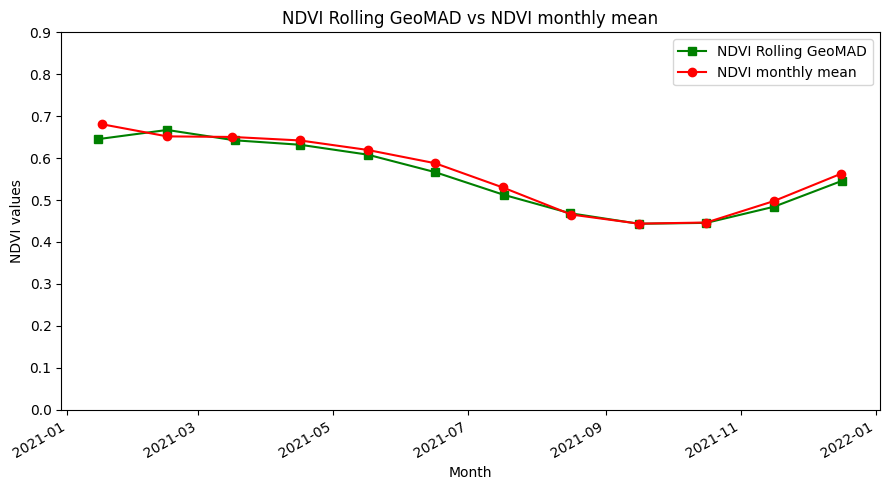

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))

# Rolling GeoMAD 
ds_NDVI_mean = ds_NDVI.NDVI.mean(['x','y'])
ds_NDVI_mean.plot(marker='s', color='green', label='NDVI Rolling GeoMAD', ax=ax)

# Monthly Mean NDVI
ndvi_mean = monthly_ndvi.ndvi_mean.mean(['x','y'])
ndvi_mean.plot(marker='o', color='red', label='NDVI monthly mean', ax=ax)

plt.title('NDVI Rolling GeoMAD vs NDVI monthly mean')
plt.ylim(0, 0.9)
plt.xlabel('Month')
plt.ylabel('NDVI values')
plt.legend()
plt.tight_layout()

From the graph above, the NDVI Rolling GeoMAD is smoother due to the rolling window being equal to 3 months as compared to the NDVI monthly mean.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-06-14'